In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [4]:
import pickle as pkl
from analysis_toolbox import *
import shapely
from collections import Counter

In [5]:
img_info,object_tbl,bb_info,hit_info=load_info()

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [6]:
def worker_polygon(bb_objects,worker_idx):
    bb = bb_objects[bb_objects["worker_id"]==worker_idx]
    xloc,yloc =  process_raw_locs([bb["x_locs"].iloc[0],bb["y_locs"].iloc[0]])    
    return Polygon(zip(xloc,yloc))

In [173]:
def compute_prjs(object_id,exclude_lst=[]):
    PDF('../bb_object_pdfs/bb_object_{}.pdf'.format(object_id),size=(500,300))
    bb_objects = bb_info[bb_info["object_id"]==object_id]
    worker_lst =  bb_objects.worker_id.unique()
    worker_lst = [w for w in worker_lst if w not in exclude_lst]
    prj_matrix = []
    worker_ijdxs=[]
    for idx in worker_lst:
    #    prj_row =[]
        for jdx in worker_lst:
            if idx!=jdx :
                worker_BB_polygon = worker_polygon(bb_objects,idx)
                worker_BB_polygon2 = worker_polygon(bb_objects,jdx)
                prj = BB_PRJ(worker_BB_polygon,worker_BB_polygon2)
         #       prj_row.append(prj)
                worker_ijdxs.append([idx,jdx])
                prj_matrix.append(prj)
    prj_matrix = np.array(prj_matrix)
    worker_ijdxs = np.array(worker_ijdxs)
    return prj_matrix,worker_ijdxs

In [8]:
from sklearn.cluster import KMeans
import numpy as np
def cluster_and_plot(object_id,prj_matrix):
    kmeans= KMeans(n_clusters=4, random_state=0)
    ypred = kmeans.fit_predict(prj_matrix)
    #print kmeans.cluster_centers_
    plt.figure()
    plt.scatter(prj_matrix[:,0],prj_matrix[:,1],c=ypred)
    plt.title("Obj {}".format(object_id),fontsize=14)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    return kmeans,ypred

In [219]:
prj_matrix

array([[ 0.90534109,  0.96129525,  0.87350038],
       [ 0.92000623,  0.86742743,  0.80659254],
       [ 0.93666047,  0.93408086,  0.87858496],
       ..., 
       [ 0.94399777,  0.94775136,  0.89730071],
       [ 0.94031063,  0.95505607,  0.90046503],
       [ 0.90196771,  0.96847434,  0.87624064]])

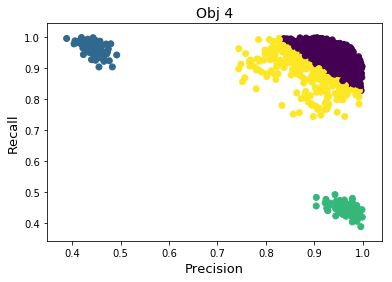

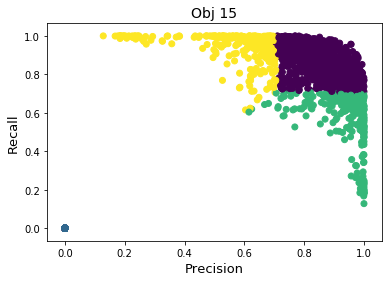

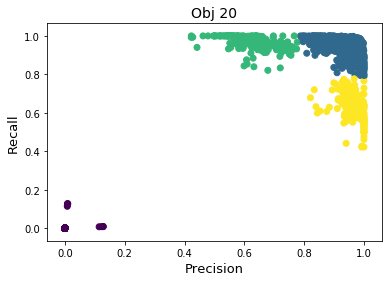

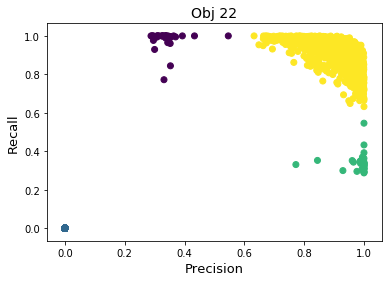

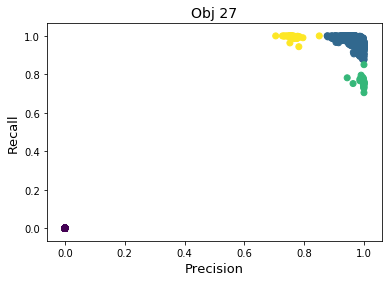

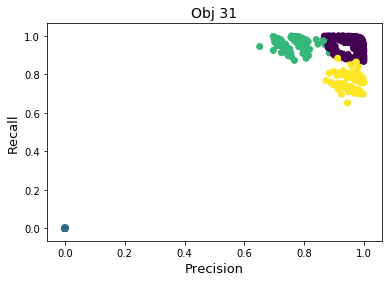

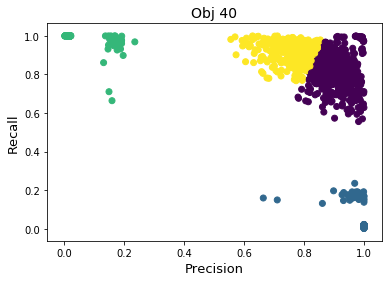

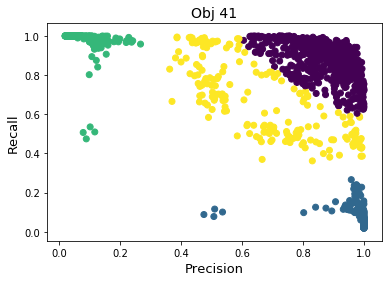

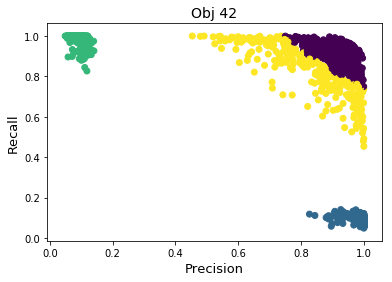

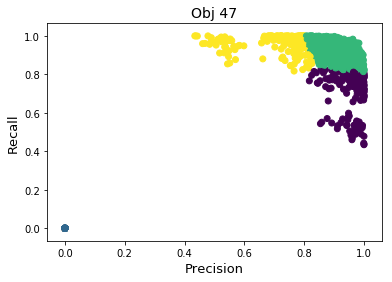

In [212]:
for obj in type_one_task_ambiguity:
    prj_matrix = compute_prjs(obj)
    cluster_and_plot(obj,prj_matrix)

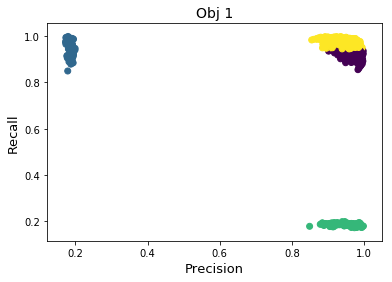

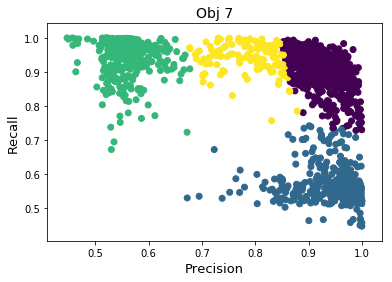

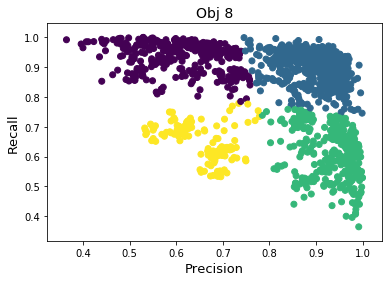

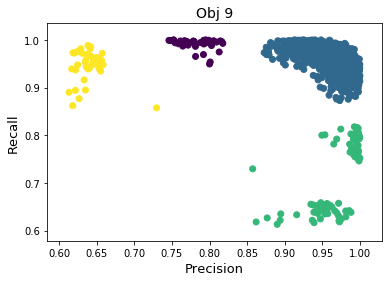

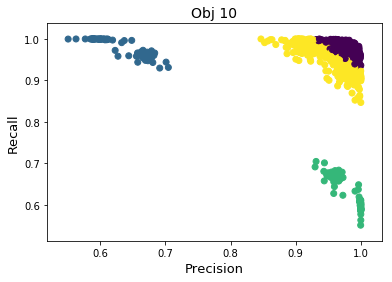

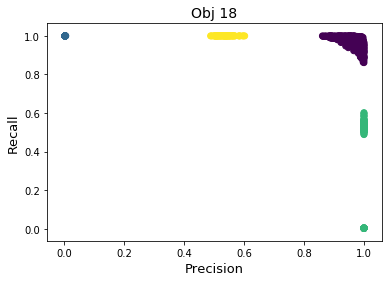

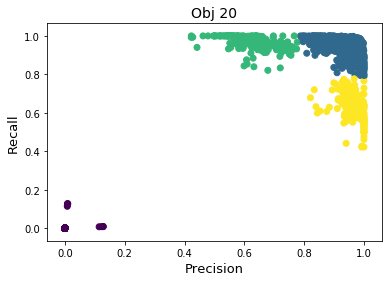

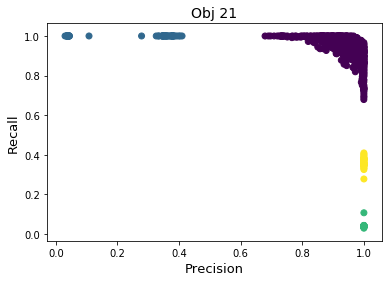

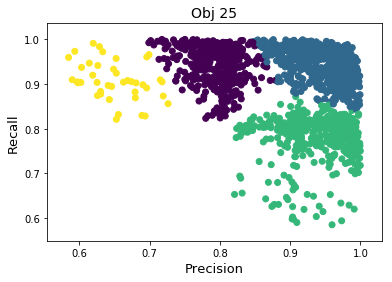

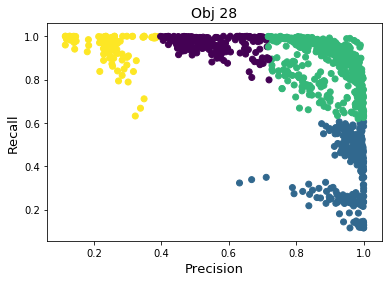

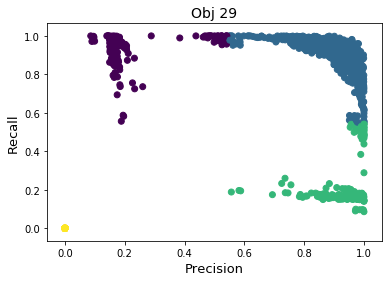

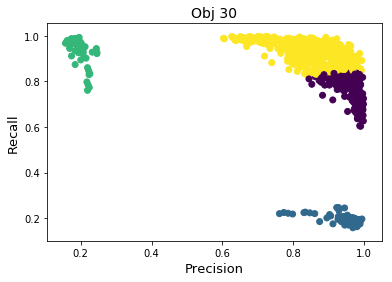

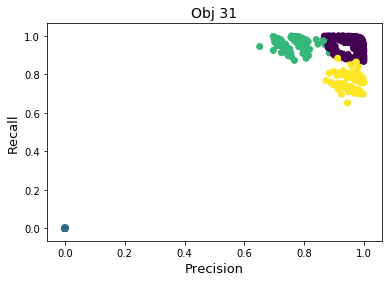

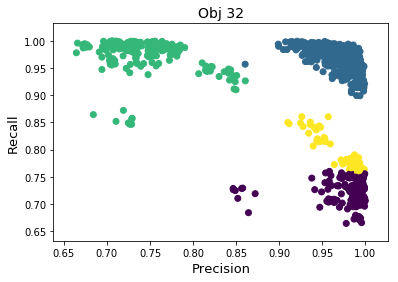

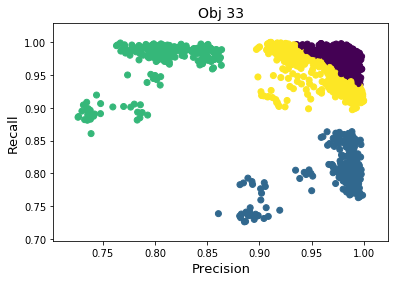

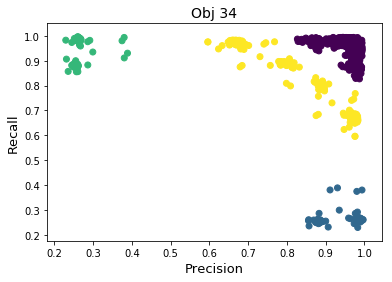

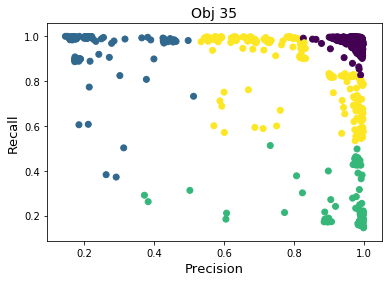

In [213]:
for obj in type_two_task_ambiguity:
    prj_matrix = compute_prjs(obj)
    cluster_and_plot(obj,prj_matrix)

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


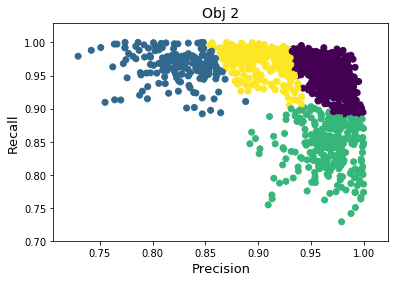

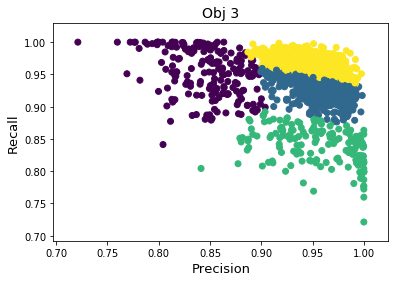

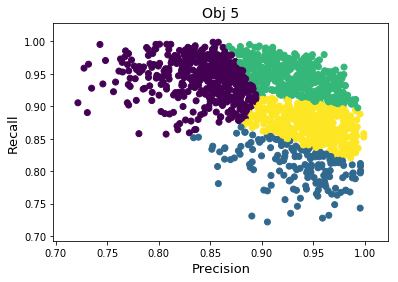

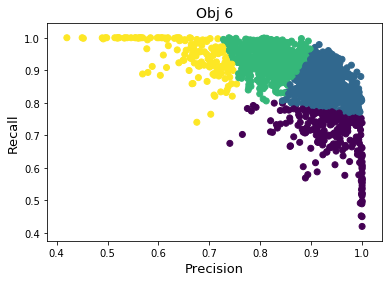

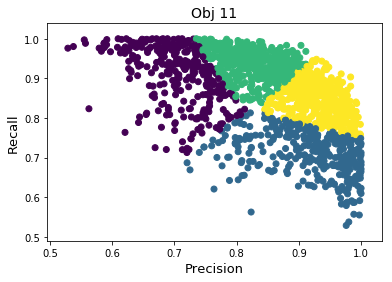

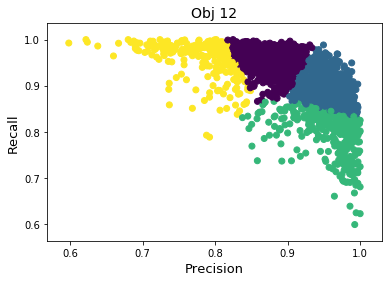

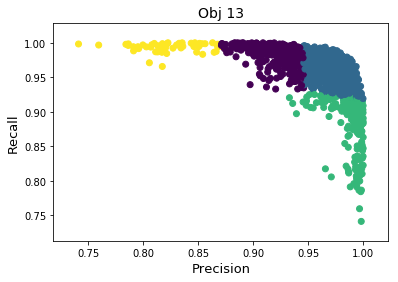

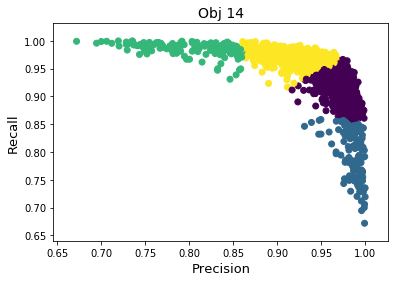

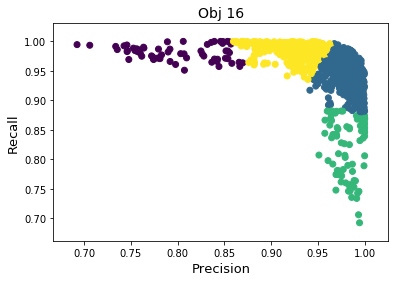

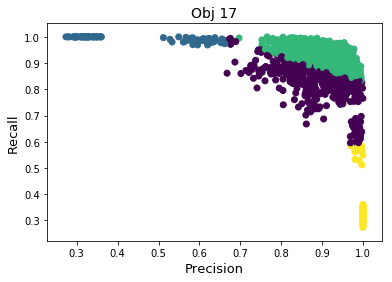

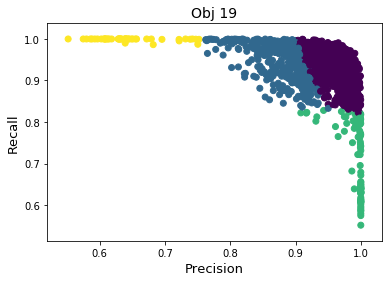

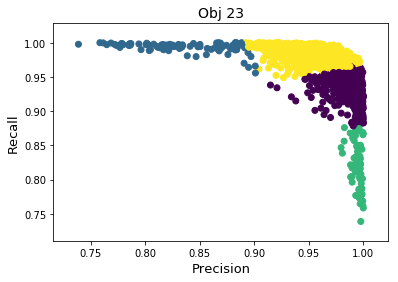

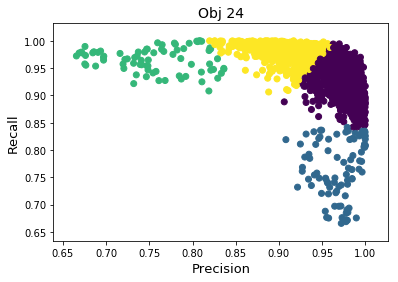

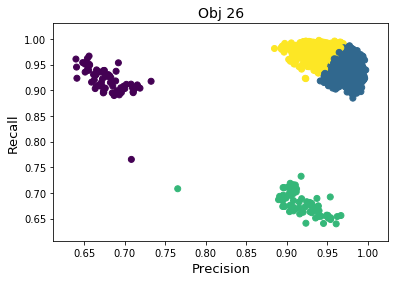

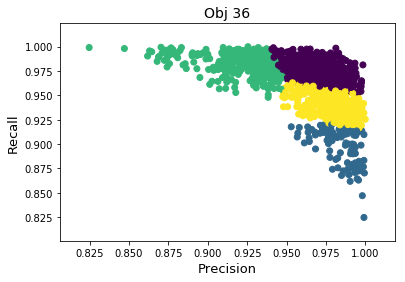

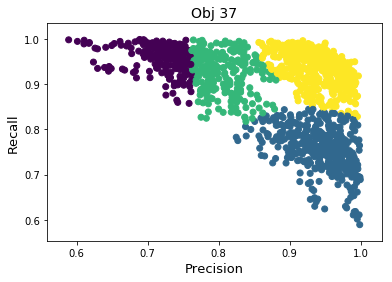

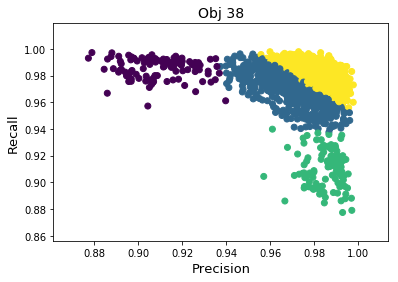

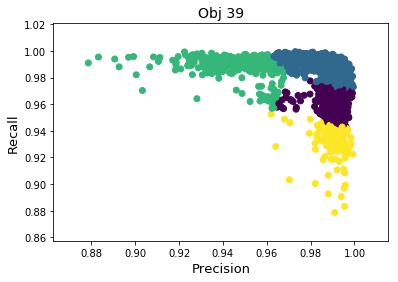

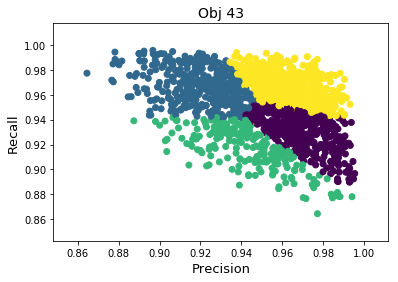

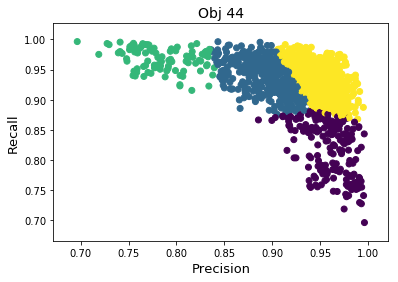

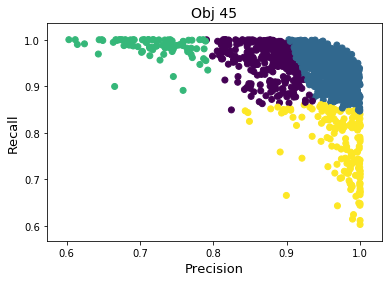

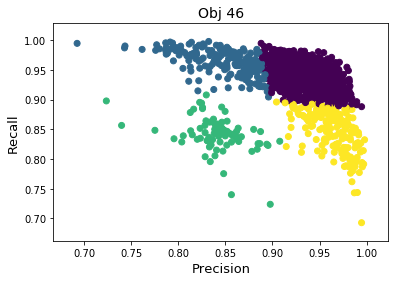

In [215]:
all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]
for obj in easy_tasks:
    prj_matrix = compute_prjs(obj)
    cluster_and_plot(obj,prj_matrix)

In [28]:
# Task difficulty
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region


In [10]:
def BB_PRJ(a,b):
    intersection_area = a.intersection(b).area
    union_area = a.union(b).area
    precision = intersection_area/float(a.area)
    recall = intersection_area/float(b.area)
    jaccard = intersection_area/float(union_area)
    return precision,recall,jaccard

In [11]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

# Looking at Type 1 error

In [12]:
type_one_task_ambiguity

[4, 15, 20, 22, 27, 31, 40, 41, 42, 47]

In [13]:
obj=15
PDF('../bb_object_pdfs/bb_object_{}.pdf'.format(obj),size=(500,300))

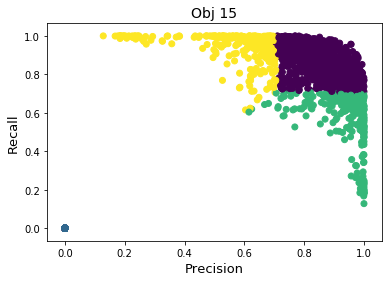

In [304]:
prj_matrix,worker_ijdxs = compute_prjs(obj)
kmeans,ypred = cluster_and_plot(obj,prj_matrix)

In [329]:
bb_objects = bb_info[bb_info["object_id"]==obj]

In [20]:
def ground_truth_T(object_id,reverse_xy = False):
    my_BBG  = pd.read_csv("../data/my_ground_truth.csv")
    ground_truth_match = my_BBG[my_BBG.object_id==object_id]
    if reverse_xy:
        x_locs,y_locs =  process_raw_locs([ground_truth_match["y_locs"].iloc[0],ground_truth_match["x_locs"].iloc[0]])
    else:
        x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    T = Polygon(zip(x_locs,y_locs))
    return T

##### if there is a cluster with P,R,J < 0.1: then this is type 1 error

In [323]:
type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
if len(type1_error_cluster)==0:
    print "No type 1 error"

In [326]:
wids_counts_dict = Counter(all_bad_worker_pairs.flatten())

type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]

wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())

In [341]:
print wids_counts_dict

Counter({56: 78, 61: 78, 129: 4, 130: 4, 131: 4, 133: 4, 137: 4, 12: 4, 142: 4, 143: 4, 16: 4, 146: 4, 148: 4, 150: 4, 156: 4, 261: 4, 161: 4, 242: 4, 46: 4, 175: 4, 51: 4, 52: 4, 181: 4, 54: 4, 9: 4, 60: 4, 68: 4, 140: 4, 214: 4, 218: 4, 219: 4, 223: 4, 225: 4, 230: 4, 234: 4, 235: 4, 272: 4, 241: 4, 114: 4, 116: 4, 118: 4})


In [362]:
mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
bad_widx = np.array(wids_counts_dict.keys())[bad_idx]

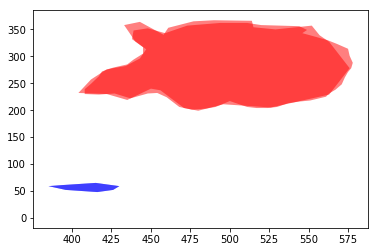

In [395]:
for widx in bad_widx:
    plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
    plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)

In [18]:
def plot_coords(obj, color='red', reverse_xy=False, linestyle='-',lw=0, fill_color="red", hatch='', show=False, invert_y=False):
    #Plot shapely polygon coord
    if type(obj) != shapely.geometry.MultiPolygon and type(obj) != list:
        obj = [obj]

    for ob in obj:
        if ob.exterior is None:
            print 'Plotting bug: exterior is None (potentially a 0 area tile). Ignoring and continuing...'
            continue
        if reverse_xy:
            x, y = ob.exterior.xy
        else:
            y, x = ob.exterior.xy
        plt.plot(x, y, linestyle, linewidth=lw, color=color, zorder=1)
        if fill_color != "":
            plt.fill_between(x, y, facecolor=fill_color, hatch=hatch, linewidth=lw, alpha=0.5)
    if invert_y:
        plt.gca().invert_yaxis()


In [25]:
type_one_task_ambiguity

[4, 15, 20, 22, 27, 31, 40, 41, 42, 47]

In [23]:
PDF('../bb_object_pdfs/bb_object_{}.pdf'.format(4),size=(500,300))

In [30]:
type_one_task_ambiguity

[15, 20, 22, 27, 31, 40, 41, 42, 47]

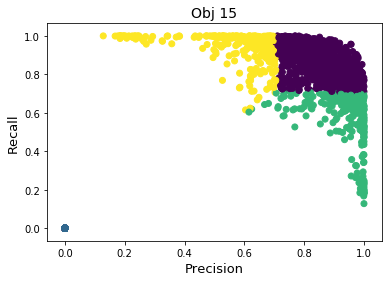

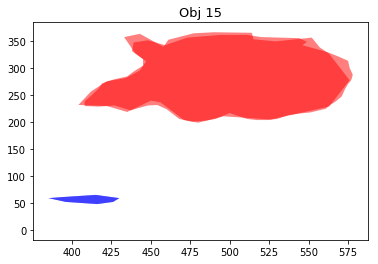

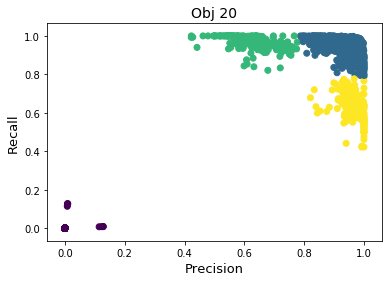

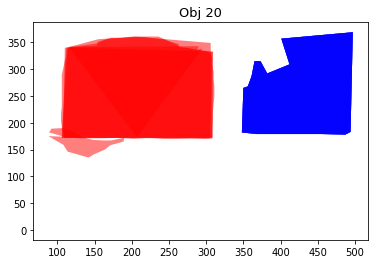

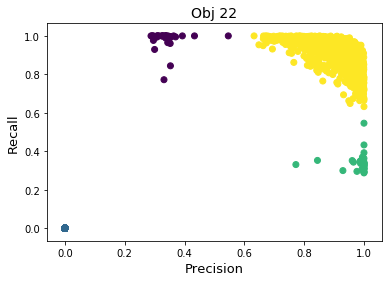

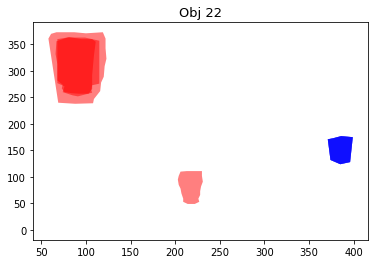

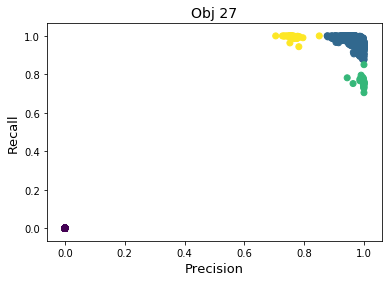

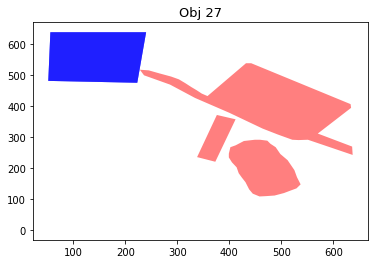

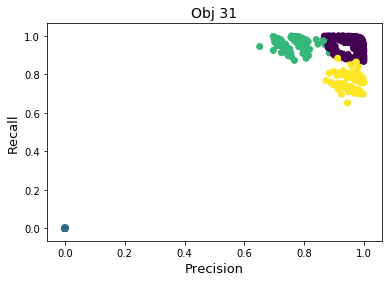

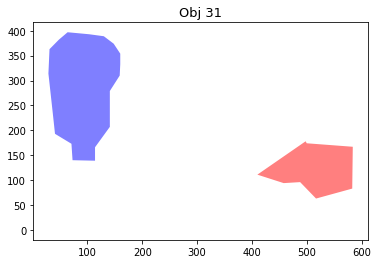

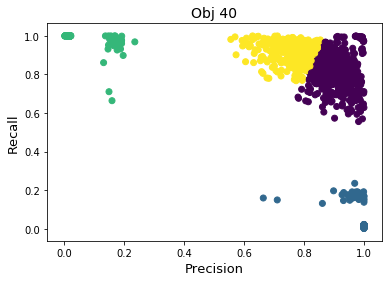

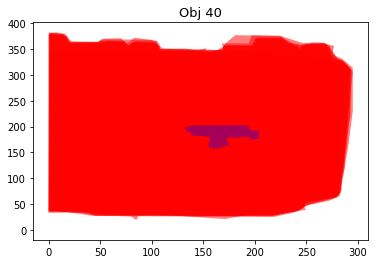

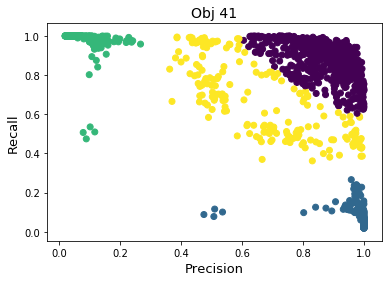

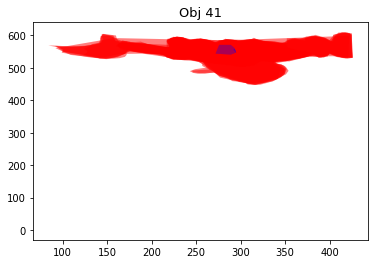

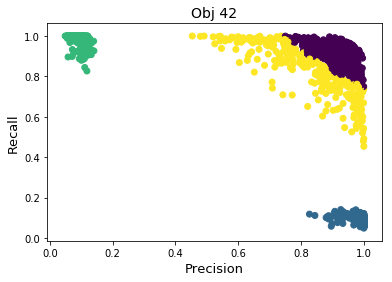

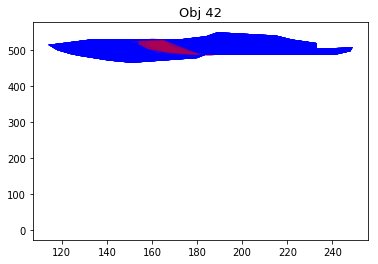

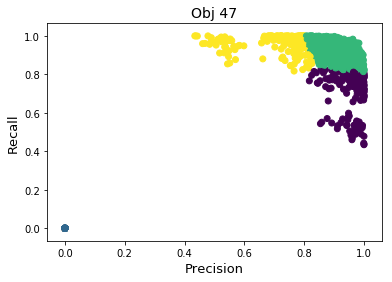

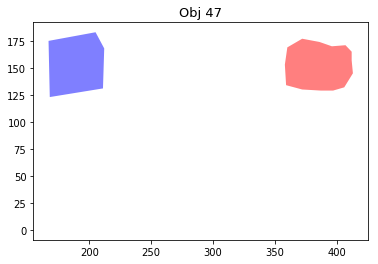

In [32]:
for obj in type_one_task_ambiguity:
    prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
    if len(type1_error_cluster)==0:
        print "No type 1 error"
    else:
        type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]
        wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        for widx in bad_widx:
            plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)

# Onto Type 2 error

In [34]:
type_two_task_ambiguity

[1, 4, 7, 8, 9, 10, 18, 20, 21, 25, 28, 29, 30, 31, 32, 33, 34, 35]

In [77]:
all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

In [79]:
print easy_tasks

[2, 3, 5, 6, 11, 12, 13, 14, 16, 17, 19, 23, 24, 26, 36, 37, 38, 39, 43, 44, 45, 46]


No type 1 error


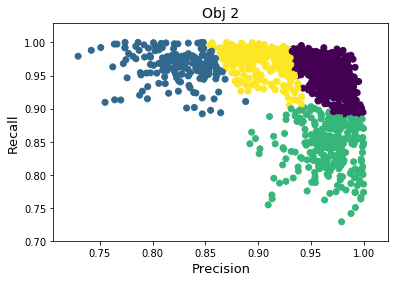

In [80]:
obj=2
prj_matrix,worker_ijdxs = compute_prjs(obj)
kmeans,ypred = cluster_and_plot(obj,prj_matrix)
bb_objects = bb_info[bb_info["object_id"]==obj]
type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
if len(type1_error_cluster)==0:
    print "No type 1 error"
else:
    type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]
    wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())
    mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
    bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
    bad_widx = np.array(wids_counts_dict.keys())[bad_idx]
    plt.figure()
    plt.title("Obj {}".format(obj),fontsize=13)
    for widx in bad_widx:
        plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
        plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)

##### Seek the two clusters with high precision low recall and high recall but low precision, these two clusters would inevitably result in two of the lowest jaccard. 

In [ ]:
# idx = np.where(ypred==1)[0]
# plt.scatter(prj_matrix[idx,0],prj_matrix[idx,1])
# jdx = np.where(ypred==2)[0]
# plt.scatter(prj_matrix[jdx,0],prj_matrix[jdx,1])
# all_bad_worker_pairs = np.concatenate([worker_ijdxs[idx],worker_ijdxs[jdx]])

In [108]:
type_one_task_ambiguity

[15, 20, 22, 27, 31, 40, 41, 42, 47]

Some of the cluster centers are biased by the fact that there are type 1 errors as a cluster, so this occupies one cluster. 

In [134]:
wids_counts_dict

Counter({2: 76,
         3: 76,
         7: 76,
         11: 76,
         46: 76,
         52: 76,
         54: 76,
         59: 76,
         68: 76,
         75: 76,
         82: 39,
         114: 76,
         116: 76,
         123: 76,
         130: 76,
         131: 76,
         133: 76,
         140: 76,
         146: 76,
         147: 76,
         148: 76,
         149: 76,
         156: 76,
         159: 76,
         161: 76,
         175: 76,
         181: 76,
         193: 76,
         218: 76,
         219: 76,
         220: 76,
         230: 76,
         233: 76,
         234: 39,
         235: 76,
         241: 76,
         246: 76,
         256: 76,
         263: 76,
         268: 76})

In [139]:
PDF('../bb_object_pdfs/bb_object_{}.pdf'.format(obj),size=(500,300))

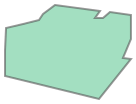

In [141]:
worker_polygon(bb_objects,268)

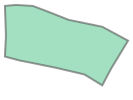

In [137]:
worker_polygon(bb_objects,82)

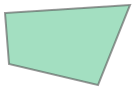

In [136]:
worker_polygon(bb_objects,234)

Note that in red is the annotations from __good workers__ and blue is ground truth.

In [153]:
jdx

array([  68,   69,   72,   82,   95,  102,  103,  106,  116,  129,  136,
        137,  140,  150,  163,  170,  171,  184,  197,  204,  205,  209,
        218,  231,  238,  239,  243,  252,  265,  272,  273,  277,  286,
        299,  306,  307,  311,  320,  333,  340,  341,  345,  354,  367,
        374,  375,  379,  388,  401,  408,  409,  413,  422,  435,  442,
        443,  447,  456,  469,  476,  477,  481,  490,  503,  544,  545,
        549,  559,  571,  578,  579,  583,  593,  605,  612,  613,  617,
        627,  639,  646,  647,  651,  655,  661,  673,  680,  681,  685,
        695,  707,  714,  715,  719,  729,  741,  748,  749,  753,  763,
        775,  782,  783,  787,  797,  809,  816,  817,  821,  831,  843,
        850,  851,  855,  865,  877,  884,  885,  889,  899,  911,  918,
        919,  923,  933,  945,  986,  987,  991, 1001, 1014, 1020, 1021,
       1025, 1035, 1048, 1054, 1055, 1063, 1069, 1082, 1088, 1089, 1093,
       1103, 1116, 1122, 1123, 1127, 1137, 1150, 11

obj 25 :labelled bad worker: 0.641025641026
obj 32 :labelled bad worker: 0.264705882353
obj 33 : Not Type 2 error
[[ 0.97640385  0.97608513  0.95343264]
 [ 0.97394404  0.80557563  0.78922318]
 [ 0.80557563  0.97394404  0.78922318]
 [ 0.9537672   0.95415504  0.91075095]]


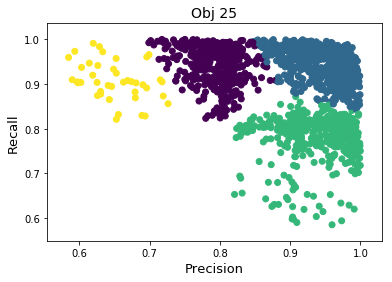

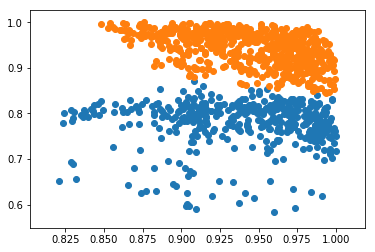

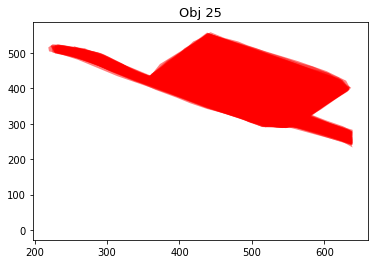

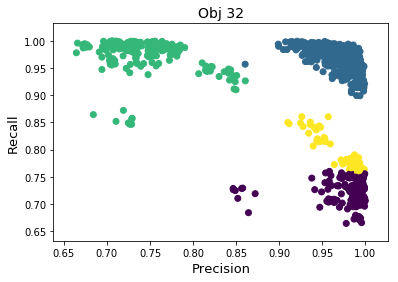

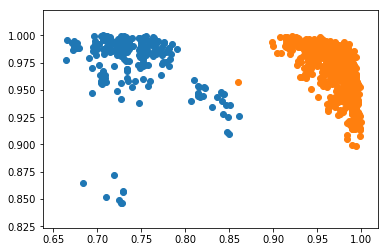

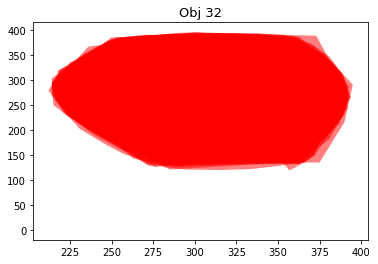

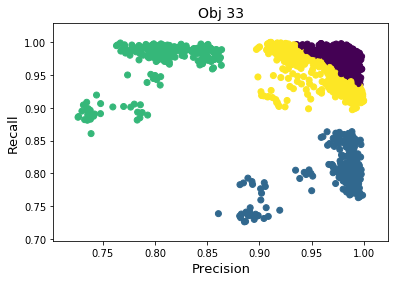

In [163]:
for obj in [25,32,33]:#type_two_task_ambiguity:
    prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    i = kmeans.cluster_centers_[:,0].argmin() #lowest precision cluster
    j = kmeans.cluster_centers_[:,1].argmin() #highest precision cluster

    if (kmeans.cluster_centers_[i][2]<=0.75) and (kmeans.cluster_centers_[j][2]<=0.75):
#         srt_idx = jaccards.argsort()[:2]
        idx = np.where(ypred==srt_idx[0])[0]
        jdx = np.where(ypred==srt_idx[1])[0]
        plt.figure()
        plt.scatter(prj_matrix[idx,0],prj_matrix[idx,1])
        plt.scatter(prj_matrix[jdx,0],prj_matrix[jdx,1])
        
        all_bad_worker_pairs = np.concatenate([worker_ijdxs[idx],worker_ijdxs[jdx]])
        wids_counts_dict = Counter(all_bad_worker_pairs.flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        good_widx = [wid for wid in bb_objects.worker_id.unique() if wid not in bad_widx]
#         for widx in bad_widx:
#             plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
#             plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
        for widx in good_widx:
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)

        print "obj",obj,":labelled bad worker:",len(bad_widx)/float(len(bb_objects))
    else:
        print "obj",obj,": Not Type 2 error"
        print kmeans.cluster_centers_
        

In [157]:
easy_tasks

[2,
 3,
 5,
 6,
 11,
 12,
 13,
 14,
 16,
 17,
 19,
 23,
 24,
 26,
 36,
 37,
 38,
 39,
 43,
 44,
 45,
 46]

In [169]:
bad_worker_records

[[11, 140, 1],
 [11, 166, 1],
 [11, 184, 1],
 [11, 193, 1],
 [11, 76, 1],
 [11, 230, 1],
 [11, 234, 1],
 [11, 240, 1],
 [11, 147, 1],
 [11, 256, 1],
 [11, 3, 1],
 [11, 133, 1],
 [11, 140, 1],
 [11, 142, 1],
 [11, 143, 1],
 [11, 273, 1],
 [11, 19, 1],
 [11, 20, 1],
 [11, 159, 1],
 [11, 161, 1],
 [11, 35, 1],
 [11, 166, 1],
 [11, 43, 1],
 [11, 46, 1],
 [11, 176, 1],
 [11, 181, 1],
 [11, 82, 1],
 [11, 147, 1],
 [11, 214, 1],
 [11, 218, 1],
 [11, 219, 1],
 [11, 220, 1],
 [11, 226, 1],
 [11, 230, 1],
 [11, 233, 1],
 [11, 234, 1],
 [11, 235, 1],
 [11, 114, 1],
 [11, 115, 1],
 [11, 116, 1],
 [11, 148, 1],
 [12, 256, 1],
 [12, 3, 1],
 [12, 133, 1],
 [12, 140, 1],
 [12, 142, 1],
 [12, 143, 1],
 [12, 273, 1],
 [12, 19, 1],
 [12, 20, 1],
 [12, 159, 1],
 [12, 161, 1],
 [12, 35, 1],
 [12, 166, 1],
 [12, 43, 1],
 [12, 46, 1],
 [12, 176, 1],
 [12, 181, 1],
 [12, 82, 1],
 [12, 147, 1],
 [12, 214, 1],
 [12, 218, 1],
 [12, 219, 1],
 [12, 220, 1],
 [12, 226, 1],
 [12, 230, 1],
 [12, 233, 1],
 [12, 234, 1

In [172]:
kmeans.cluster_centers_

array([[  8.56945825e-01,   8.56945825e-01,   7.42666467e-01],
       [ -2.66453526e-15,  -2.22044605e-15,  -6.66133815e-16],
       [  9.45692864e-01,   5.68247759e-01,   5.44736887e-01],
       [  5.68247759e-01,   9.45692864e-01,   5.44736887e-01]])

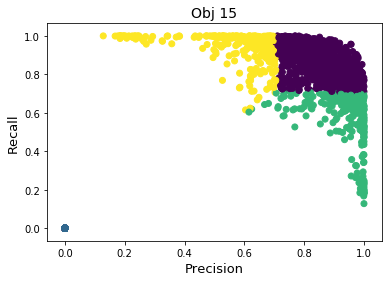

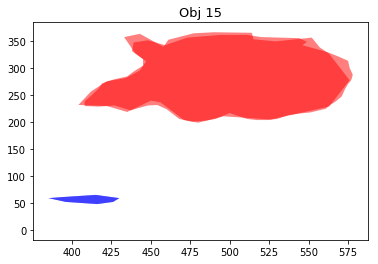

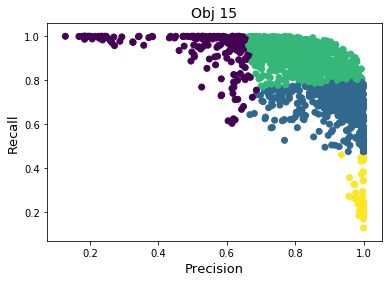

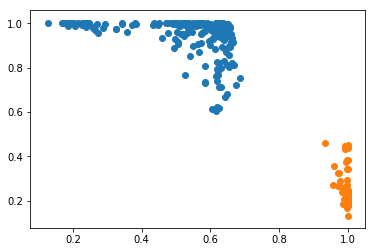

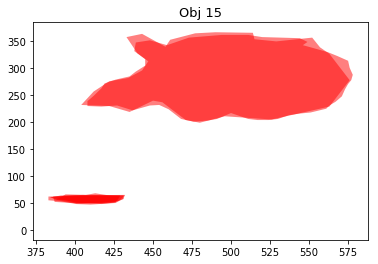

In [188]:
bad_worker_records =[]
for obj in object_lst[14:15]:
    # First pass, get rid of type 1 error
    prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
    if len(type1_error_cluster)==0:
        print "obj",obj,": Not Type 1 error"
    else:
        type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]
        wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        for widx in bad_widx:
            plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
        for bwidx in bad_widx:
            bad_worker_records.append([obj,bwidx,1]) #obj,bad worker id, error type 1
    
    # Second pass, get rid of type 2 error
    prj_matrix,worker_ijdxs = compute_prjs(obj,exclude_lst=bad_widx)
    kmeans,ypred = cluster_and_plot(obj,prj_matrix)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    i = kmeans.cluster_centers_[:,0].argmin() #lowest precision cluster
    j = kmeans.cluster_centers_[:,1].argmin() #highest precision cluster
    if (kmeans.cluster_centers_[i][2]<=0.75) and (kmeans.cluster_centers_[j][2]<=0.75):
    #if (kmeans.cluster_centers_[i][2]<=0.75) and (kmeans.cluster_centers_[j][2]<=0.75):
#         srt_idx = jaccards.argsort()[:2]
        idx = np.where(ypred==i)[0]
        jdx = np.where(ypred==j)[0]
        plt.figure()
        plt.scatter(prj_matrix[idx,0],prj_matrix[idx,1])
        plt.scatter(prj_matrix[jdx,0],prj_matrix[jdx,1])
        
        all_bad_worker_pairs = np.concatenate([worker_ijdxs[idx],worker_ijdxs[jdx]])
        wids_counts_dict = Counter(all_bad_worker_pairs.flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx = np.array(wids_counts_dict.keys())[bad_idx]
        plt.figure()
        plt.title("Obj {}".format(obj),fontsize=13)
        good_widx = [wid for wid in bb_objects.worker_id.unique() if wid not in bad_widx]
#         for widx in bad_widx:
#             plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
#             plot_coords(ground_truth_T(obj),color="blue",fill_color="blue",reverse_xy=True)
        for widx in good_widx:
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True)
        for bwidx in bad_widx:
            bad_worker_records.append([obj,bwidx,2]) #obj,bad worker id, error type 1
    else:
        print "obj",obj,": Not Type 2 error"

In [186]:
kmeans.cluster_centers_

array([[ 0.52275104,  0.94681476,  0.50138126],
       [ 0.92601995,  0.68195177,  0.64339378],
       [ 0.81896615,  0.8999362 ,  0.7454679 ],
       [ 0.99186941,  0.26707803,  0.26617332]])

In [171]:
bad_worker_records

[[11, 256, 2],
 [11, 3, 2],
 [11, 133, 2],
 [11, 140, 2],
 [11, 142, 2],
 [11, 143, 2],
 [11, 273, 2],
 [11, 19, 2],
 [11, 20, 2],
 [11, 159, 2],
 [11, 161, 2],
 [11, 35, 2],
 [11, 166, 2],
 [11, 43, 2],
 [11, 46, 2],
 [11, 176, 2],
 [11, 181, 2],
 [11, 82, 2],
 [11, 147, 2],
 [11, 214, 2],
 [11, 218, 2],
 [11, 219, 2],
 [11, 220, 2],
 [11, 226, 2],
 [11, 230, 2],
 [11, 233, 2],
 [11, 234, 2],
 [11, 235, 2],
 [11, 114, 2],
 [11, 115, 2],
 [11, 116, 2],
 [11, 148, 2],
 [15, 56, 1],
 [15, 61, 1],
 [15, 129, 2],
 [15, 130, 2],
 [15, 131, 2],
 [15, 133, 2],
 [15, 137, 2],
 [15, 12, 2],
 [15, 142, 2],
 [15, 143, 2],
 [15, 16, 2],
 [15, 146, 2],
 [15, 148, 2],
 [15, 150, 2],
 [15, 156, 2],
 [15, 261, 2],
 [15, 161, 2],
 [15, 46, 2],
 [15, 175, 2],
 [15, 51, 2],
 [15, 52, 2],
 [15, 181, 2],
 [15, 54, 2],
 [15, 9, 2],
 [15, 56, 2],
 [15, 61, 2],
 [15, 68, 2],
 [15, 225, 2],
 [15, 140, 2],
 [15, 214, 2],
 [15, 218, 2],
 [15, 219, 2],
 [15, 272, 2],
 [15, 235, 2],
 [15, 241, 2],
 [15, 242, 2],
 